In [37]:
#import libraries
from keras.datasets import cifar10
import numpy as np
from matplotlib import pyplot as plt
from keras.layers.convolutional import Conv2D,MaxPooling2D,UpSampling2D
from keras.layers.normalization import  BatchNormalization
from keras.layers import Reshape,Input,Activation, Flatten, Dropout, Dense, Add, AveragePooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
import keras
import copy
from datetime import datetime
from keras import regularizers
from keras.callbacks import ModelCheckpoint

In [38]:
#import cifar data and split it into train and test
(x_train, _), (x_test, _) = cifar10.load_data()

In [110]:
class DataProcessing:
    
    def __init__(self,x_train,x_test):
        
        self.x_train = x_train
        self.x_test = x_test
        
    
    def add_patches(self):
        
        x_train_patch = copy.deepcopy(self.x_train)
        x_test_patch = copy.deepcopy(self.x_test)
        x_train_crop = []
        x_test_crop = []
        #adding patches to the train images
        for i in range(len(self.x_train)):
            
            box = np.array([1]*8*8*3).reshape([8,8,3])
            x, y = np.random.randint(0,32-8, size=2)
            x_train_patch[i][x:x+8, y:y+8] = box
            x_train_crop.append((x,x+8,y,y+8))
            
        #adding patches to the test images    
        for j in range(len(self.x_test)):
            
            box = np.array([1]*8*8*3).reshape([8,8,3])
            x, y, = np.random.randint(0,32-8, size=2)
            x_test_patch[j][x:x+8, y:y+8] = box
            x_test_crop.append((x,x+8,y,y+8))
            
        return x_train_patch, x_test_patch, x_train_crop, x_test_crop
    
    
    def display_loss_plots(self,history):
        
        # Plot 2 curves on the same plot
        indices = np.float32(range(50))
        plt.title("Validation and Training Loss Actual")
        plt.plot(indices, history.history['loss'], 'b',label=r'Training Loss') 
        plt.plot(indices, history.history['val_loss'], 'r', label=r'Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend();
        
        
    def reconstruct_image(self,x_test_crop,i,x_test_patch):
    
        x_pred = ae.predict(x_test_patch[i].reshape(1,32,32,3))
        x_pred = x_pred.reshape(32,32,3)
        coord = x_test_crop[i]
        x_reconstructed = copy.deepcopy(x_test_patch[i])
        x_reconstructed[coord[0]:coord[1], coord[2]:coord[3]] = x_pred[coord[0]:coord[1], coord[2]:coord[3]]
        
        return x_reconstructed, x_pred
        
            
    def display_results(self,image_range,x_test_crop,x_test_patch,x_test):
        
        plt.figure(figsize=(10,10))
        titles = ["Actual Image", "Patch Image", "Decoded Image", "Reconstructed Image"]
        
        count = 0
        for i in range(len(image_range)):
            recon_image, decoded_image = self.reconstruct_image(x_test_crop,image_range[i],x_test_patch)
            image_list = [x_test,x_test_patch,decoded_image,recon_image] 
            for j in range(1,5):
                img_type = image_list[j-1]
                count = count + 1
                if i == 0:
                    plt.subplot(4,4,count)    
                    plt.xticks([])    
                    plt.yticks([])    
                    plt.grid(False)
                    if j == 1 or j == 2:
                        
                        plt.imshow(img_type[image_range[i]])
                    else:
                        
                        plt.imshow(img_type)
                    plt.title(titles[j-1])
              
                else:
                    plt.subplot(4,4,count)    
                    plt.xticks([])    
                    plt.yticks([])    
                    plt.grid(False)    
                    if j == 1 or j == 2:
                       
                        plt.imshow(img_type[image_range[i]])
                    else:
                        
                        plt.imshow(img_type)  

        plt.show()

        

In [40]:
class AutoEncoder:
    
    def __init__(self,x_train,x_train_patch):
        
        self.x_train = x_train
        self.x_train_patch = x_train_patch
        
    def model(self):
        
        X_inp = Input(shape=self.x_train[0].shape)
        
        #Encoder
        X = Conv2D(32, (3,3), name = 'conv1_enc',padding = 'same', activation='relu',kernel_regularizer=regularizers.l2(0.01))(X_inp)
        X = MaxPooling2D((2,2), padding = 'same')(X)
        X = BatchNormalization()(X)
        X = Conv2D(32, (3,3), name = 'conv2_enc',padding = 'same', activation='relu',kernel_regularizer=regularizers.l2(0.01) )(X)
        X = MaxPooling2D((2,2), padding = 'same')(X)
        X = BatchNormalization()(X)
        
        #Decoder
        X = Conv2D(32, (3,3), name = 'conv1_dec',padding = 'same', activation='relu',kernel_regularizer=regularizers.l2(0.01) )(X)
        X = UpSampling2D((2,2))(X)
        X = BatchNormalization()(X)
        X = Conv2D(32, (3,3), name = 'conv2_dec',padding = 'same', activation='relu',kernel_regularizer=regularizers.l2(0.01) )(X)
        X = UpSampling2D((2,2))(X)
        X = BatchNormalization()(X)
        recon_image = Conv2D(3, (3,3), name = 'conv3_dec',padding = 'same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(X)
        
        autoencoder = Model(X_inp, recon_image)
        
        return autoencoder
        

In [41]:

if __name__ == '__main__':
    
    
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    data_proc = DataProcessing(x_train,x_test)
    x_train_patch, x_test_patch, x_train_crop, x_test_crop = data_proc.add_patches()
    
    ae_obj = AutoEncoder(x_train,x_train_patch)
    ae = ae_obj.model()
    opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-5)
    ae.compile(optimizer = opt, loss  = 'mse')
    
    mydir = 'IP_Checkpoints/'
    
    filepath="IP_Checkpoints/weights-improvement-{epoch:02d}.hdf5"
    
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
    logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
    
    callbacks_list = [checkpoint,tensorboard_callback]
    
    ae.summary()
    histpry = ae.fit(x_train_patch, x_train, epochs = 50, batch_size = 128, shuffle = True, validation_data=(x_test_patch, x_test))
    
    
    
    

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv1_enc (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
conv2_enc (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 8, 8, 32)          128 

In [105]:
x_pred = ae.predict(x_test_patch[90].reshape(1,32,32,3))
x_pred = x_pred.reshape(32,32,3)



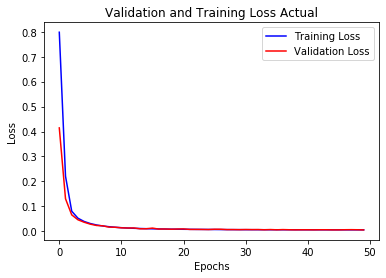

In [112]:
data_proc = DataProcessing(x_train,x_test)
data_proc.display_loss_plots(histpry)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


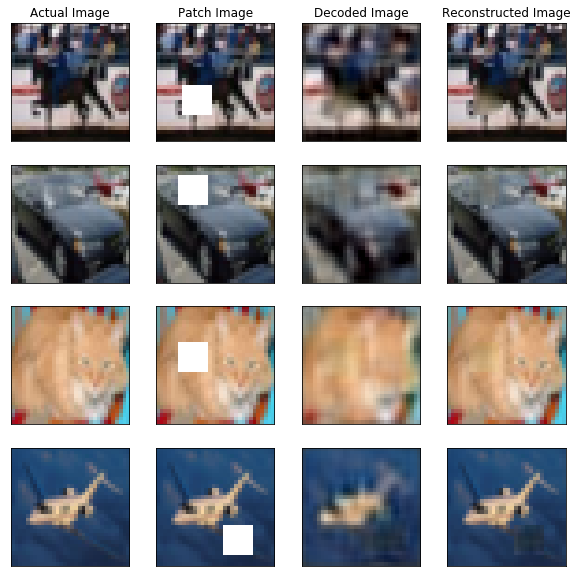

In [113]:
data_proc.display_results(list(range(203,207)),x_test_crop,x_test_patch,x_test)

In [89]:
list(range(78,83))

[78, 79, 80, 81, 82]

In [90]:
for j in range(1,5):
    print("hello")

hello
hello
hello
hello
